In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd
import theano
import arviz as az
import seaborn as sns

In [40]:
sales = pd.read_csv("data/sales-ds6040sum2021.csv")
sales.head()

,sales,food,con,neur,store
0,1.363821,0,0.216553,1.290224,0
1,-1.119747,1,0.216553,1.290224,0
2,-0.180141,0,0.216553,1.290224,0
3,-2.282334,1,0.216553,1.290224,0
4,0.673304,0,0.216553,1.290224,0


In [119]:
sales.groupby('store').mean().sort_values('con', ascending=False)

,sales,food,con,neur
store,,,,
2,-0.522865,0.5,0.738900,0.093054
14,4.260734,0.5,0.587351,-0.646036
10,-0.363217,0.5,0.410372,0.330495
17,1.609038,0.5,0.325928,0.796620
19,-0.736324,0.5,0.306285,-0.070093
0,-0.800092,0.5,0.216553,1.290224
15,1.248723,0.5,0.139971,-0.173394
6,0.127343,0.5,-0.130894,-0.874896
1,-0.463849,0.5,-0.135665,-2.276493


## Question 1 Bayesian Hierarchical Modelling

You have been hired by a regional chain of coffee shops to help improve sales and to examine how the personality characteristics of individual store managers might impact the sales numbers of both coffee and food. The client as the following questions they need answered: 

- How does conscientiousness and neuroticism impact the sales of coffee and food, and are coffee and food impacted differently?
- Once you control for the personality characteristics of the store managers, what stores should be performing well? (i.e. the rest of the employees might be great, but the store manager might be bringing sales down) 

IMPORTANT: This part of the assignment is meant to simulate the experience of a working data scientist. For this section, prepare your response as though you are preparing a report for your client. This means that it needs to be readable, well formatted, and detail your reasoning.

---
Work Flow

In [41]:
store_idx = sales.store.values
n_stores = len(sales.store.unique())

In [108]:
with pm.Model() as hierarchical_model_centered:
    # Priors for the fixed effects
    # a - overall intercept, level of sales at mean levels of con and neur
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_a_f = pm.Normal('mu_a_f', mu=0., sd=1e5)
    sigma_a_f = pm.HalfCauchy('sigma_a_f', 5)
    
    # Sales intercepts as offsets
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=20)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    a_offset_f = pm.Normal('a_offset_f', mu=0, sd=1, shape=20)
    a_f = pm.Deterministic("a_f", mu_a_f + a_offset_f * sigma_a_f)
    
    # Store level effect of con as offset
    b_offset = pm.Normal('b_offset', mu=0, sd=1)
    b = pm.Deterministic("b", b_offset)
    b_offset_f = pm.Normal('b_offset_f', mu=0, sd=1)
    b_f = pm.Deterministic("b_f", b_offset_f)
    
    # Store level effect of neur as offset
    c_offset = pm.Normal('c_offset', mu=0, sd=1)
    c = pm.Deterministic("c", c_offset)
    c_offset_f = pm.Normal('c_offset_f', mu=0, sd=1)
    c_f = pm.Deterministic("c_f", c_offset_f)
    
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    # Linear regression
    food = sales.food.values
    con = sales.con.values
    neur = sales.neur.values
    
    # sales_est = b0[store_idx] + b1[store_idx] * food \
    #         + b2[store_idx] * con + b3[store_idx] * food * con \
    #         + b4[store_idx] * neur + b5[store_idx] * food * neur\
    #         + b6[store_idx] * neur * con + b7[store_idx] * food * neur * con
    sales_est = a[store_idx] + a_f[store_idx]*food \
            + b *con + b_f*con*food \
            + c *neur + c_f*neur*food
    
    # Data likelihoode
    sales_like = pm.Normal('sales_like', 
                           mu=sales_est, 
                           sd=eps, 
                           observed=sales.sales)


In [109]:
with hierarchical_model_centered:
    hierarchical_trace = pm.sample(1000, n_init=50000, tune=1000, target_accept = 0.9)

/usr/local/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, c_offset_f, c_offset, b_offset_f, b_offset, a_offset_f, a_offset, sigma_a_f, mu_a_f, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [112]:
pm.summary(hierarchical_trace).sort_values('mean',ascending=False).head(30)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[14],3.582,0.435,2.807,4.420,0.010,0.007,1965.0,2836.0,1.0
a_offset[14],2.529,0.599,1.423,3.679,0.015,0.011,1565.0,1984.0,1.0
a[12],1.729,0.408,1.019,2.550,0.009,0.006,2295.0,2658.0,1.0
a[17],1.573,0.359,0.934,2.300,0.007,0.005,2640.0,2964.0,1.0
a[13],1.492,0.516,0.539,2.467,0.012,0.008,1908.0,2450.0,1.0
sigma_a,1.263,0.249,0.864,1.726,0.008,0.005,1100.0,1989.0,1.0
a[4],1.262,0.510,0.364,2.302,0.012,0.008,1953.0,2389.0,1.0
a_offset_f[8],1.110,0.531,0.059,2.059,0.009,0.007,3155.0,3018.0,1.0
a[3],1.087,0.370,0.381,1.780,0.008,0.006,2140.0,2402.0,1.0
a[15],1.065,0.279,0.538,1.582,0.004,0.003,4546.0,3324.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'mu_a_f'}>,
        <AxesSubplot:title={'center':'mu_a_f'}>],
       [<AxesSubplot:title={'center':'a_offset'}>,
        <AxesSubplot:title={'center':'a_offset'}>],
       [<AxesSubplot:title={'center':'a_offset_f'}>,
        <AxesSubplot:title={'center':'a_offset_f'}>],
       [<AxesSubplot:title={'center':'b_offset'}>,
        <AxesSubplot:title={'center':'b_offset'}>],
       [<AxesSubplot:title={'center':'b_offset_f'}>,
        <AxesSubplot:title={'center':'b_offset_f'}>],
       [<AxesSubplot:title={'center':'c_offset'}>,
        <AxesSubplot:title={'center':'c_offset'}>],
       [<AxesSubplot:title={'center':'c_offset_f'}>,
        <AxesSubplot:title={'center':'c_offset_f'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_a_f'}>,
        <AxesSubplot:ti

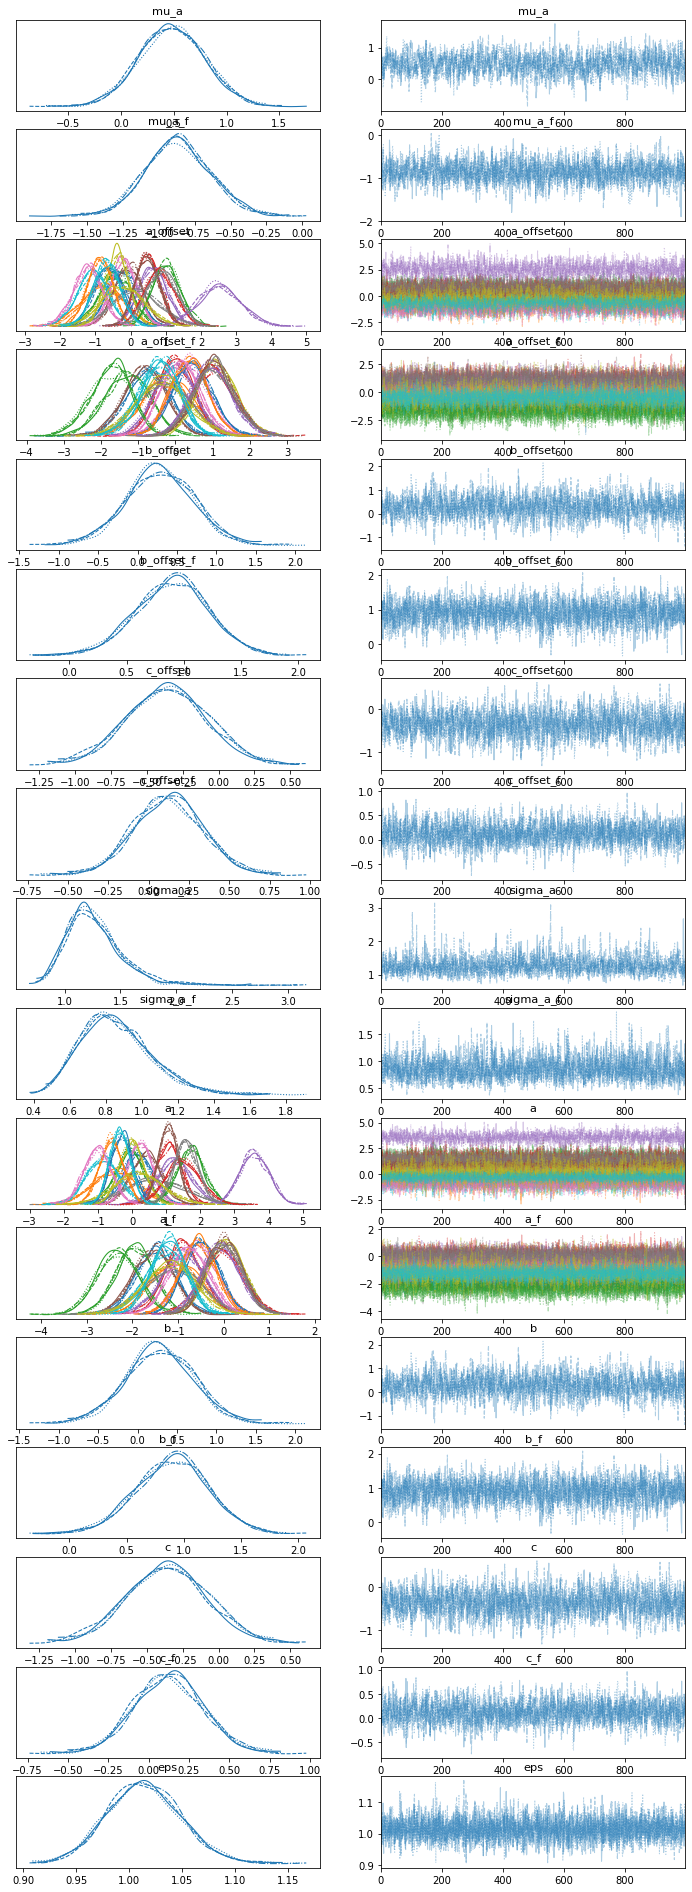

In [111]:
az.rcParams["plot.max_subplots"] = 50# This finishes without error
az.plot_trace(hierarchical_trace)

In [47]:
pm.summary(hierarchical_trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_b0,0.466,0.301,-0.123,1.022,0.008,0.006,1326.0,1790.0,1.00
b0[0],0.432,0.685,-0.837,1.840,0.020,0.015,1224.0,1420.0,1.01
b0[1],0.240,0.749,-1.322,1.645,0.025,0.019,897.0,801.0,1.02
b0[2],0.314,0.649,-1.047,1.447,0.016,0.013,1673.0,1083.0,1.01
b0[3],0.698,0.643,-0.446,2.002,0.018,0.014,1261.0,1869.0,1.00
...,...,...,...,...,...,...,...,...,...
sigma_b4,0.594,0.490,0.031,1.497,0.041,0.029,127.0,229.0,1.02
sigma_b5,0.465,0.342,0.036,1.095,0.038,0.027,68.0,167.0,1.04
sigma_b6,1.852,1.272,0.128,3.985,0.097,0.068,156.0,510.0,1.03
sigma_b7,1.042,0.776,0.101,2.434,0.059,0.042,150.0,349.0,1.02


End Work Flow

---

1. Problem Statement - What problem are you tackling?

2. Approach- Describe the model you are using. Present it both in equation form, as well as a written description of the model. Importantly, you are not writing this for another data scientist, you are writing this for someone who is capable of understanding what a regression is, and what these sorts of models can provide, but has never worked with data analyses or statistics before (so smart, but without the same knowledge base you have.)

3. Prior Rationale- List your prior choices and why those were chosen.

4. Findings- This is where you present your findings.

5. Summary- This is where you summarize and interpret what your analyses uncovered. Again, this is for the client, so it needs to be usable information for them.

6. Diagnostics- This is where you put information/plots as to how the estimator performed. This is for technical reference (I like to always have these in the reports I create, but this information is not really for a client per say, more for another data scientist to validate your work.) This doesn’t need to be long.

## Question 2
Continuing our adventures in classifying wine, in this section you will be applying (pseudo)-Bayesian Model Averaging with logistic regression.

1. First, revisit your HW2 and calculate the misclassification rate and the cross tabs for 3 variable models that used flat priors that performed best on the testing data. You will have 1 model for LDA and 1 model for QDA. 

2. Next, use the provided BMA Wine class to fit a Bayesian Model Averaged logistic regression using the training data. Output the variable inclusion probabilities using the summary() function and interpret. 

3. Finally, obtain the miss-classification rates and cross tabs for the BMA model applied to the training data and the testing data. Compare the performance of the BMA models to the performance of the best LDA and QDA models.

LDA, QDA, and Bayesian Model Averging Models

In [2]:
from mpmath import mp
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations
mp.dps = 50

#This class is based on the BMA class provided by Bill Basener in: https://www.kaggle.com/billbasener/bayesian-model-averaging-logistic-regression
#It has been modified to allow for multinomial regression (logistic regression for more than 2 categories)
#Specifically, I've hardcoded the model as a 3 category multinomial regression, so this code doesn't generalize to any other model
class BMA_Wine:
    
    def __init__(self, y, X, **kwargs):
        # Setup the basic variables.
        self.y = y
        self.X = X
        self.names = list(X.columns)
        self.nRows, self.nCols = np.shape(X)
        self.likelihoods = mp.zeros(self.nCols,1)
        self.likelihoods_all = {}
        self.coefficients_mp = mp.zeros(self.nCols,2)
        self.coefficients = np.zeros((self.nCols, 2))
        self.probabilities = np.zeros(self.nCols)
        # Check the max model size. (Max number of predictor variables to use in a model.)
        # This can be used to reduce the runtime but not doing an exhaustive sampling.
        if 'MaxVars' in kwargs.keys():
            self.MaxVars = kwargs['MaxVars']
        else:
            self.MaxVars = self.nCols  
        # Prepare the priors if they are provided.
        # The priors are provided for the individual regressor variables.
        # The prior for a model is the product of the priors on the variables in the model.
        if 'Priors' in kwargs.keys():
            if np.size(kwargs['Priors']) == self.nCols:
                self.Priors = kwargs['Priors']
            else:
                print("WARNING: Provided priors error.  Using equal priors instead.")
                print("The priors should be a numpy array of length equal tot he number of regressor variables.")
                self.Priors = np.ones(self.nCols)  
        else:
            self.Priors = np.ones(self.nCols)  
        if 'Verbose' in kwargs.keys():
            self.Verbose = kwargs['Verbose'] 
        else:
            self.Verbose = False 
        if 'RegType' in kwargs.keys():
            self.RegType = kwargs['RegType'] 
        else:
            self.RegType = 'LS' 
        
    def fit(self):
        # Perform the Bayesian Model Averaging
        
        # Initialize the sum of the likelihoods for all the models to zero.  
        # This will be the 'normalization' denominator in Bayes Theorem.
        likelighood_sum = 0
        
        # To facilitate iterating through all possible models, we start by iterating thorugh
        # the number of elements in the model.  
        max_likelihood = 0
        for num_elements in range(1,self.MaxVars+1): 
            
            if self.Verbose == True:
                print("Computing BMA for models of size: ", num_elements)
            
            # Make a list of all index sets of models of this size.
            Models_current = list(combinations(list(range(self.nCols)), num_elements)) 
             
            # Occam's window - compute the candidate models to use for the next iteration
            # Models_previous: the set of models from the previous iteration that satisfy (likelihhod > max_likelihhod/20)
            # Models_next:     the set of candidate models for the next iteration
            # Models_current:  the set of models from Models_next that can be consturcted by adding one new variable
            #                    to a model from Models_previous
                                   
            
            # Iterate through all possible models of the given size.
            for model_index_set in Models_current:
                
                # Compute the linear regression for this given model. 
                model_X = self.X.iloc[:,list(model_index_set)]

                model_regr = sm.MNLogit(self.y, model_X).fit(disp=0)
                
                # Compute the likelihood (times the prior) for the model. 
                model_likelihood = mp.exp(-model_regr.bic/2)*np.prod(self.Priors[list(model_index_set)])
                
                if self.Verbose == True:
                    pass
                    #print("Model Variables:",model_index_set,"likelihood=",model_likelihood)
                self.likelihoods_all[str(model_index_set)] = model_likelihood
                
                # Add this likelihood to the running tally of likelihoods.
                likelighood_sum = mp.fadd(likelighood_sum, model_likelihood)
                # Add this likelihood (times the priors) to the running tally
                # of likelihoods for each variable in the model.
                for idx, i in zip(model_index_set, range(num_elements)):
                    self.likelihoods[idx] = mp.fadd(self.likelihoods[idx], model_likelihood, prec=2000)
                    for j in np.arange(model_regr.params.shape[1]):

                        self.coefficients_mp[idx,j] = mp.fadd(self.coefficients_mp[idx,j], model_regr.params[j][i]*model_likelihood, prec=2000)
                max_likelihood = np.max([max_likelihood,model_likelihood]) # get the new max likelihood if it is this model
                
                    

        # Divide by the denominator in Bayes theorem to normalize the probabilities 
        # sum to one.
        self.likelighood_sum = likelighood_sum
        for idx in range(self.nCols):
            self.probabilities[idx] = mp.fdiv(self.likelihoods[idx],likelighood_sum, prec=1000)
            for j in range(2):
                self.coefficients[idx,j] = mp.fdiv(self.coefficients_mp[idx,j],likelighood_sum, prec=1000)
        
        # Return the new BMA object as an output.
        return self
    
 
    def predict_MAP(self,true_class, data):
        data = np.asarray(data)
        result = np.zeros((data.shape[0],3))
        temp = sm.MNLogit(true_class, exog=np.asarray(data))
        result = temp.predict(params = self.coefficients, exog = np.asarray(data))
        result = pd.DataFrame(result, columns= ["A", "C", "F"])
        res_MAP = result.idxmax(axis=1)
        to_return = pd.DataFrame({'TrueClass':true_class, 'MAP':res_MAP})
        return to_return
    

    def misclass_rate(self, true_class, data):
        maps = self.predict_MAP(true_class, data)
        
        
        maps['Mis_class'] = maps['MAP']  == maps['TrueClass']
        
        mis_class =  1 - maps['Mis_class'].mean()
        
        return mis_class
    def misclass_xtabs(self, true_class, data):
        maps = self.predict_MAP(true_class, data)
        
        xtabs = pd.crosstab(maps['MAP'], maps['TrueClass'])        
        return xtabs
    
    def summary(self):
        # Return the BMA results as a data frame for easy viewing.
        df = pd.DataFrame([self.names, list(self.probabilities), list(self.coefficients)], 
             ["Variable Name", "Probability", "Avg. Coefficient"]).T
        return df  

In [11]:
from scipy.stats import multivariate_normal

class LDA():
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors =  np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        self.sigma = dataset.cov()
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = self.sigma))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 
    def predict_MAP(self, data = None):        
        if data is None:
            data = self.training_data
        dens_list = self.predict_probs(data).drop('True Class', axis = 1)
        map_list = dens_list.idxmax(axis = 1)
        maps = {'MAP Class': map_list}
        maps = pd.DataFrame(maps)
        maps['True Class'] = data[self.class_var]
        return maps
    def misclass_rate(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        
        maps['Mis_class'] = maps['MAP Class']  == maps['True Class']
        
        mis_class =  1 - maps['Mis_class'].mean()
        
        return mis_class
    def misclass_xtabs(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        xtabs = pd.crosstab(maps['MAP Class'], maps['True Class'])        
        return xtabs
    def misclass_pairplot(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        temp_dat = data.copy(deep = True)
        temp_dat['Mis-Classified'] = maps['MAP Class']  != maps['True Class']
        plot = sns.pairplot(temp_dat,hue="Mis-Classified", height = 1.5, aspect = 1.5)   
        return plot

In [7]:
class QDA(LDA):
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors = np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        gb = dataset.groupby(class_var)
        self.sigma = {x: gb.get_group(x).cov() for x in gb.groups}
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = np.asarray(self.sigma[ind])))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 
    def predict_MAP(self, data = None):        
        if data is None:
            data = self.training_data
        dens_list = self.predict_probs(data).drop('True Class', axis = 1)
        map_list = dens_list.idxmax(axis = 1)
        maps = {'MAP Class': map_list}
        maps = pd.DataFrame(maps)
        maps['True Class'] = data[self.class_var]
        return maps

Wine data Load

In [4]:
train = pd.read_csv("../HW2/data/whitewine-training-ds6040.csv")
train.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,wine_quality
0,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C
1,-0.640290,0.206999,0.056475,-0.946679,0.142355,-1.246502,-0.149673,-0.008274,0.711107,0.011581,-0.831034,C
2,1.476825,0.010158,0.558982,0.092590,0.187465,-0.319775,-0.973515,0.353398,0.452130,-0.423446,-0.347387,C
3,-0.757907,0.403840,-1.451043,0.112199,-0.038083,-0.319775,-0.055520,0.287640,-0.065824,-0.162430,-0.750426,C
4,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C


In [5]:
test = pd.read_csv("../HW2/data/whitewine-testing-ds6040.csv")
test.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,wine_quality
0,2.074706,2.095780,-0.370398,-0.442945,-0.924246,-0.963499,-0.878403,-0.770506,-1.210376,-0.994742,1.581632,F
1,0.752463,0.031237,0.597571,-1.000570,-0.077157,-1.447827,-0.290673,-0.380327,0.659670,-0.373157,-0.151371,F
2,-1.050596,-0.170181,0.032922,-1.000570,0.016964,-1.750531,-2.571065,-0.563331,0.728931,1.225203,-0.068847,F
3,-1.892024,1.541879,-1.822352,-1.040400,-0.783065,-1.750531,-2.053863,-1.129610,2.252672,-0.106764,0.591345,F
4,-0.569781,-0.371600,-0.370398,1.010863,0.252266,-0.176466,0.649694,0.955952,0.867453,-0.373157,-0.811562,F


#### Question 2 - 1
First, revisit your HW2 and calculate the misclassification rate and the cross tabs for 3 variable models that used flat priors that performed best on the testing data. You will have 1 model for LDA and 1 model for QDA. 

In [14]:
import itertools
error_rates_combinations = []
for i in itertools.combinations(train.columns[:-1], 3):
    combination = list(i) + ["wine_quality"]
    flat_priors_lda = LDA(train[combination], 'wine_quality')
    training_error = flat_priors_lda.misclass_rate()
    testing_error = flat_priors_lda.misclass_rate(data = test[combination])
    error_rates_combinations.append([",".join(combination[:-1]), training_error, testing_error])
df_error_rates_combinations_lda = pd.DataFrame(error_rates_combinations)
df_error_rates_combinations_lda.columns = ["combinations",\
                                       "training error",\
                                       "testing error"]

In [18]:
df_error_rates_combinations_lda.sort_values('testing error', ascending=False)[0:1]

,combinations,training error,testing error
14,"fixed.acidity,citric.acid,pH",0.756765,0.744186


In [19]:
import itertools
error_rates_combinations = []
for i in itertools.combinations(train.columns[:-1], 3):
    combination = list(i) + ["wine_quality"]
    flat_priors_qda = QDA(train[combination], 'wine_quality')
    training_error = flat_priors_qda.misclass_rate()
    testing_error = flat_priors_qda.misclass_rate(data = test[combination])
    error_rates_combinations.append([",".join(combination[:-1]), training_error, testing_error])
df_error_rates_combinations_qda = pd.DataFrame(error_rates_combinations)
df_error_rates_combinations_qda.columns = ["combinations",\
                                       "training error",\
                                       "testing error"]

In [20]:
df_error_rates_combinations_qda.sort_values('testing error', ascending=False)[0:1]

,combinations,training error,testing error
81,"citric.acid,residual.sugar,chlorides",0.7618,0.770349


#### Question 3 -2
Next, use the provided BMA Wine class to fit a Bayesian Model Averaged logistic regression using the training data. Output the variable inclusion probabilities using the summary() function and interpret.

In [67]:
bma_model = BMA_Wine(train['wine_quality'], add_constant(train.iloc[:,:-1]), RegType='Logit', Verbose=True)

In [68]:
bma_model.fit()

Computing BMA for models of size:  1
Computing BMA for models of size:  2
Computing BMA for models of size:  3
Computing BMA for models of size:  4
Computing BMA for models of size:  5
Computing BMA for models of size:  6
Computing BMA for models of size:  7
Computing BMA for models of size:  8
Computing BMA for models of size:  9
Computing BMA for models of size:  10
Computing BMA for models of size:  11
Computing BMA for models of size:  12


In [69]:
bma_model.summary()

,Variable Name,Probability,Avg. Coefficient
0,const,1.0,"[3.5548050259163233, 2.5617193891280996]"
1,fixed.acidity,0.050937,"[0.006081316362694351, 0.012836499255148485]"
2,volatile.acidity,1.0,"[0.252005132198438, 0.9405138587589457]"
3,citric.acid,0.00038,"[1.7243943761242395e-05, 1.3338342052969118e-05]"
4,residual.sugar,1.0,"[-0.4297881784368994, -0.8224412258831187]"
5,chlorides,0.000432,"[5.931264746435702e-05, 6.510663234552933e-05]"
6,free.sulfur.dioxide,0.237846,"[-0.06733716611614582, -0.09003553653546773]"
7,total.sulfur.dioxide,0.002822,"[0.000523484644990109, 0.0008579730874492004]"
8,density,0.238925,"[0.17396196112903814, 0.2939245486737622]"
9,pH,0.035454,"[-0.008840094487387816, -0.012972530705769082]"


# INTERPRETATION

#### Question 3 - 3
Finally, obtain the miss-classification rates and cross tabs for the BMA model applied to the training data and the testing data. Compare the performance of the BMA models to the performance of the best LDA and QDA models.

In [34]:
bma_model.misclass_rate(train['wine_quality'], train.iloc[:,:-1])

0.3590308370044053

In [36]:
bma_model.misclass_xtabs(train['wine_quality'], train.iloc[:,:-1])

TrueClass,A,C,F
MAP,,,
A,7,107,18
C,78,1251,203
F,15,720,779


In [35]:
bma_model.misclass_rate(test['wine_quality'], test.iloc[:,:-1])

0.3540697674418605

In [37]:
bma_model.misclass_xtabs(test['wine_quality'], test.iloc[:,:-1])

TrueClass,A,C,F
MAP,,,
A,7,47,10
C,61,632,158
F,12,321,472
